# Scaled Dot-Product Attention From Scratch

This notebook is a report that shows scaled dot-product attention starting from scratch. 

**Methodology**
- implement attention in PyTorch from scratch
- understand why scaling by sqrt(d_k) is needed
- visualize attention distributions with heatmaps
- look at how increasing d_k affects sharpness, entropy, and gradients

Understand why scaling keeps logits in a stable range and makes attention behavior more consistent across dimensions.


## Background: What Attention Is

Attention maps each query to a weighted combination of values.

- **Query (Q):** what this token is looking for
- **Key (K):** what each token offers for matching
- **Value (V):** what information gets aggregated

Essentially, compute query-key similarity scores, convert them to probabilities with softmax, and take a weighted sum of values.

Flow diagram:

Q @ K^T -> logits -> softmax -> attention weights -> weights @ V


## Why We Scale by sqrt(d_k) 

1. **Dot products grow with dimension:** if query/key entries are roughly zero-mean with unit-scale variance, Var(q · k) grows with d_k, so raw logits get larger as dimension increases.
2. **Softmax saturation:** very large logits push softmax toward near one-hot outputs, which reduces useful gradient signal for most positions.
3. **Scaling normalizes logits:** dividing by sqrt(d_k) keeps score magnitudes in a more comparable range across dimensions.

**Prediction:** as d_k increases without scaling, attention should become more peaked (higher max weight, lower entropy), and gradients may become less stable.


## Conceptual Understanding and Method Choices

This project uses **scaled dot-product attention** since it is the core mechanism introduced in the Transformer architecture. I chose to implement it from scratch (instead of only using a library) to make each step transparent: score computation, scaling, softmax normalization, and value aggregation.

Why these methods were chosen:
- **Scaled vs unscaled comparison:** directly tests the class claim that dividing by sqrt(d_k) prevents logit magnitudes from growing too large.
- **Controlled sweep over d_k:** isolates dimensionality as the key independent variable
- **Entropy and max-weight metrics:** quantify distribution sharpness, connecting softmax to observable behavior.
- **Gradient norms:** link attention saturation to optimization behavior.
- **Heatmaps:** show visual evidence that with scalar metrics.

## imports and Setting a Seed 


In [16]:
import math
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

torch.set_printoptions(precision=4, sci_mode=False)
np.set_printoptions(precision=4, suppress=True)

from pathlib import Path

OUTPUT_DIR = Path("outputs")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)


def save_current_figure(name, dpi=200):
    path = OUTPUT_DIR / name
    plt.savefig(path, dpi=dpi, bbox_inches="tight")
    print(f"Saved: {path}")


Using device: cpu


Reproducibility note:
- The same random seed pattern is used for each condition (SEED + d_k).
- Scaled and unscaled conditions at each d_k share the same sampled Q/K/V generation process.
- This keeps comparisons fair and isolates the effect of scaling.

## Scaled Dot-Product Attention
T = sequences length 

Assumed tensor shape: [T, d_k].

- Inputs: `Q, K, V` each shaped `[T, d_k]`
- Logits: `Q @ K^T` shaped `[T, T]`
- Scaling: divide logits by `sqrt(d_k)` when `scale=True`
- Softmax: across key positions (`dim=-1`)
- Output: `weights @ V` shaped `[T, d_k]`


In [17]:
def scaled_dot_product_attention(Q, K, V, mask=None, scale=True, stabilize=True):
    # Scaled dot-product attention for [T, d_k] tensors.
    assert Q.ndim == K.ndim == V.ndim == 2, "Expected [T, d_k] tensors"
    assert Q.shape == K.shape == V.shape, "Q, K, V must have identical shapes"

    T, d_k = Q.shape
    logits = Q @ K.T

    if scale:
        logits = logits / math.sqrt(d_k)

    if mask is not None:
        assert mask.shape == (T, T), "mask must be shape [T, T]"
        logits = logits.masked_fill(mask == 0, float("-inf"))

    if stabilize:
        finite_max = torch.nan_to_num(logits, neginf=-1e9).max(dim=-1, keepdim=True).values
        logits = logits - finite_max

    weights = torch.softmax(logits, dim=-1)
    output = weights @ V
    return output, weights, logits


### PyTorch check 
This compares the custom implementation to `torch.nn.functional.scaled_dot_product_attention` on the same inputs.
A very small max absolute difference supports technical correctness.


In [18]:
Q_ref = torch.randn(6, 8, device=device)
K_ref = torch.randn(6, 8, device=device)
V_ref = torch.randn(6, 8, device=device)

out_custom, _, _ = scaled_dot_product_attention(Q_ref, K_ref, V_ref, scale=True)
out_torch = torch.nn.functional.scaled_dot_product_attention(
    Q_ref.unsqueeze(0),
    K_ref.unsqueeze(0),
    V_ref.unsqueeze(0),
    dropout_p=0.0,
).squeeze(0)

max_abs_diff = (out_custom - out_torch).abs().max().item()
print(f'Max absolute difference vs torch builtin: {max_abs_diff:.8f}')


Max absolute difference vs torch builtin: 0.00000018


## Tests on Small Matrices


In [19]:
Q_small = torch.tensor([[1.0, 0.0], [0.0, 1.0], [1.0, 1.0]], device=device)
K_small = torch.tensor([[1.0, 0.0], [0.0, 1.0], [1.0, 1.0]], device=device)
V_small = torch.tensor([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]], device=device)

out_small, attn_small, logits_small = scaled_dot_product_attention(Q_small, K_small, V_small, scale=True)

print('Logits:')
print(logits_small.cpu())
print('\nAttention weights:')
print(attn_small.cpu())
print('\nRow sums (should be 1):')
print(attn_small.sum(dim=-1).cpu())
print('\nOutput:')
print(out_small.cpu())


Logits:
tensor([[ 0.0000, -0.7071,  0.0000],
        [-0.7071,  0.0000,  0.0000],
        [-0.7071, -0.7071,  0.0000]])

Attention weights:
tensor([[0.4011, 0.1978, 0.4011],
        [0.1978, 0.4011, 0.4011],
        [0.2483, 0.2483, 0.5035]])

Row sums (should be 1):
tensor([1., 1., 1.])

Output:
tensor([[3.0000, 4.0000],
        [3.4067, 4.4067],
        [3.5105, 4.5105]])


### Additional checks with slighty larger matrices

This second test uses more tokens and a larger feature size to confirm shapes and normalization still behave correctly.


In [20]:
# Larger test case: 5 tokens, d_k = 4
Q_big = torch.tensor([
    [1.0, 0.0, 1.0, 0.0],
    [0.0, 1.0, 0.0, 1.0],
    [1.0, 1.0, 0.0, 0.0],
    [0.0, 0.0, 1.0, 1.0],
    [1.0, 0.5, 0.5, 1.0],
], device=device)

K_big = torch.tensor([
    [1.0, 0.0, 1.0, 0.0],
    [0.0, 1.0, 0.0, 1.0],
    [1.0, 1.0, 0.0, 0.0],
    [0.0, 0.0, 1.0, 1.0],
    [0.5, 1.0, 1.0, 0.5],
], device=device)

V_big = torch.tensor([
    [1.0, 2.0, 0.0, 1.0],
    [3.0, 0.0, 1.0, 2.0],
    [2.0, 1.0, 3.0, 0.0],
    [0.0, 2.0, 2.0, 3.0],
    [1.0, 1.0, 1.0, 1.0],
], device=device)

out_big, attn_big, logits_big = scaled_dot_product_attention(Q_big, K_big, V_big, scale=True)

print('Big logits shape:', logits_big.shape)
print('Big attention shape:', attn_big.shape)
print('Big output shape:', out_big.shape)

print('\nBig attention weights (rounded):')
print(attn_big.cpu().round(decimals=4))

print('\nBig row sums (should be 1):')
print(attn_big.sum(dim=-1).cpu())


Big logits shape: torch.Size([5, 5])
Big attention shape: torch.Size([5, 5])
Big output shape: torch.Size([5, 4])

Big attention weights (rounded):
tensor([[0.2976, 0.1095, 0.1805, 0.1805, 0.2318],
        [0.1095, 0.2976, 0.1805, 0.1805, 0.2318],
        [0.1805, 0.1805, 0.2976, 0.1095, 0.2318],
        [0.1805, 0.1805, 0.1095, 0.2976, 0.2318],
        [0.1892, 0.1892, 0.1892, 0.1892, 0.2430]])

Big row sums (should be 1):
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000])


### Masking edge-case sanity check
Verifies that masked key positions receive near-zero probability for every query.

In [21]:
T_mask = 4
Q_mask = torch.randn(T_mask, 4, device=device)
K_mask = torch.randn(T_mask, 4, device=device)
V_mask = torch.randn(T_mask, 4, device=device)

# Mask out the final key column for all queries.
mask = torch.ones(T_mask, T_mask, device=device)
mask[:, -1] = 0

_, attn_masked, _ = scaled_dot_product_attention(Q_mask, K_mask, V_mask, mask=mask, scale=True)

print('Masked attention matrix:')
print(attn_masked.cpu())
print('\nMasked column (should be ~0):')
print(attn_masked[:, -1].cpu())
print('Max masked probability:', attn_masked[:, -1].max().item())


Masked attention matrix:
tensor([[0.1504, 0.0215, 0.8281, 0.0000],
        [0.3394, 0.4589, 0.2017, 0.0000],
        [0.2986, 0.1457, 0.5557, 0.0000],
        [0.7373, 0.0403, 0.2224, 0.0000]])

Masked column (should be ~0):
tensor([0., 0., 0., 0.])
Max masked probability: 0.0


## Visualizations: Heatmap Function


In [22]:
def plot_attention_heatmap(weights, x_labels=None, y_labels=None, title="Attention Heatmap", ax=None):
    # Plot [T, T] attention matrix: rows are queries, columns are keys.
    if ax is None:
        _, ax = plt.subplots(figsize=(5, 4))

    data = weights.detach().cpu().numpy()
    im = ax.imshow(data, cmap="viridis", aspect="auto")

    T = data.shape[0]
    if x_labels is None:
        x_labels = [f"t{i}" for i in range(T)]
    if y_labels is None:
        y_labels = x_labels

    ax.set_xticks(range(T))
    ax.set_yticks(range(T))
    ax.set_xticklabels(x_labels, rotation=45, ha="right")
    ax.set_yticklabels(y_labels)
    ax.set_xlabel("Key Positions")
    ax.set_ylabel("Query Positions")
    ax.set_title(title)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    return ax


## Experiment Design

- **Independent variable:** d_k in {4, 16, 64, 256}
- **Conditions:** scaled vs unscaled
- **Controlled factors:** same token count, fixed seed pattern, same synthetic data process
- **Measurements:** max_weight, entropy, and gradient norms (||dL/dQ||, ||dL/dK||)

**Hypothesis:** without scaling, larger d_k produces more peaked attention (higher max weight, lower entropy). With scaling, metrics should be more stable across d_k.


## Metric Definitions

- **Max attention weight (per query):** how concentrated attention is on one key.
- **Attention entropy (per query):** how spread out the distribution is.
  - Formula: `H(p) = -sum_i p_i log(p_i)`
- **Gradient norm:** how much gradient signal flows through attention parameters.


In [23]:
def max_attention(attn):
    # Mean of row-wise maximum attention weights.
    return attn.max(dim=-1).values.mean()


def attention_entropy(attn, eps=1e-12):
    # Mean row-wise entropy: -sum(p log p).
    p = attn.clamp(min=eps)
    return (-(p * torch.log(p)).sum(dim=-1)).mean()


def run_condition(T, d_k, scaled, seed):
    torch.manual_seed(seed)
    Q = torch.randn(T, d_k, device=device, requires_grad=True)
    K = torch.randn(T, d_k, device=device, requires_grad=True)
    V = torch.randn(T, d_k, device=device)

    output, weights, _ = scaled_dot_product_attention(Q, K, V, scale=scaled)

    loss = torch.nn.functional.mse_loss(output, torch.zeros_like(output))
    loss.backward()

    return {
        "d_k": d_k,
        "scaled": scaled,
        "mean_max_weight": max_attention(weights).item(),
        "mean_entropy": attention_entropy(weights).item(),
        "grad_norm_q": Q.grad.norm().item(),
        "grad_norm_k": K.grad.norm().item(),
        "weights": weights.detach(),
    }


## Run d_k x (Scaled/Unscaled)


In [24]:
T = 8 #sequence length
d_k_values = [4, 16, 64, 256]
token_labels = ["I", "really", "enjoy", "building", "models", "from", "first", "principles"]

records = []
weights_lookup = {}

for d_k in d_k_values:
    for scaled in [True, False]:
        result = run_condition(T=T, d_k=d_k, scaled=scaled, seed=SEED + d_k)
        weights_lookup[(d_k, scaled)] = result.pop("weights")
        records.append(result)

results_df = pd.DataFrame(records).sort_values(["d_k", "scaled"]).reset_index(drop=True)
results_df

results_df.to_csv(OUTPUT_DIR / "attention_sweep_results.csv", index=False)
results_df


,d_k,scaled,mean_max_weight,mean_entropy,grad_norm_q,grad_norm_k
0,4,False,0.472408,1.490452,0.172545,0.160474
1,4,True,0.285367,1.896224,0.049016,0.052782
2,16,False,0.834383,0.440413,0.196614,0.227972
3,16,True,0.469838,1.517428,0.082821,0.093654
4,64,False,0.824134,0.525305,0.489250,0.521015
5,64,True,0.282738,1.849734,0.030680,0.035202
6,256,False,0.994217,0.029603,0.175974,0.188997
7,256,True,0.367958,1.725610,0.039397,0.041567


### Multi-seed robustness check

In [25]:
robust_rows = []
seed_list = list(range(SEED, SEED + 8))  # 8 seeds

for seed in seed_list:
    for d_k in d_k_values:
        for scaled in [True, False]:
            r = run_condition(T=T, d_k=d_k, scaled=scaled, seed=seed + d_k)
            robust_rows.append({
                'seed': seed,
                'd_k': d_k,
                'scaled': scaled,
                'mean_max_weight': r['mean_max_weight'],
                'mean_entropy': r['mean_entropy'],
            })

robust_df = pd.DataFrame(robust_rows)
robust_summary = (
    robust_df.groupby(['d_k', 'scaled'])[['mean_max_weight', 'mean_entropy']]
    .agg(['mean', 'std'])
    .reset_index()
)

# Flatten multi-index columns.
robust_summary.columns = [
    'd_k', 'scaled',
    'max_weight_mean', 'max_weight_std',
    'entropy_mean', 'entropy_std'
]

display(robust_summary.round(4))
robust_summary.to_csv(OUTPUT_DIR / 'attention_robustness_summary.csv', index=False)

,d_k,scaled,max_weight_mean,max_weight_std,entropy_mean,entropy_std
0,4,False,0.5107,0.0999,1.3484,0.2166
1,4,True,0.3243,0.0584,1.7922,0.0980
2,16,False,0.7642,0.0665,0.6375,0.1583
3,16,True,0.3778,0.0590,1.6920,0.1053
4,64,False,0.8579,0.0452,0.3520,0.1214
5,64,True,0.3585,0.0426,1.7083,0.0779
6,256,False,0.9087,0.0602,0.2140,0.1250
7,256,True,0.3406,0.0324,1.7362,0.0534


## Heatmaps How Patterns Change


Saved: outputs/attention_heatmap_gallery.png


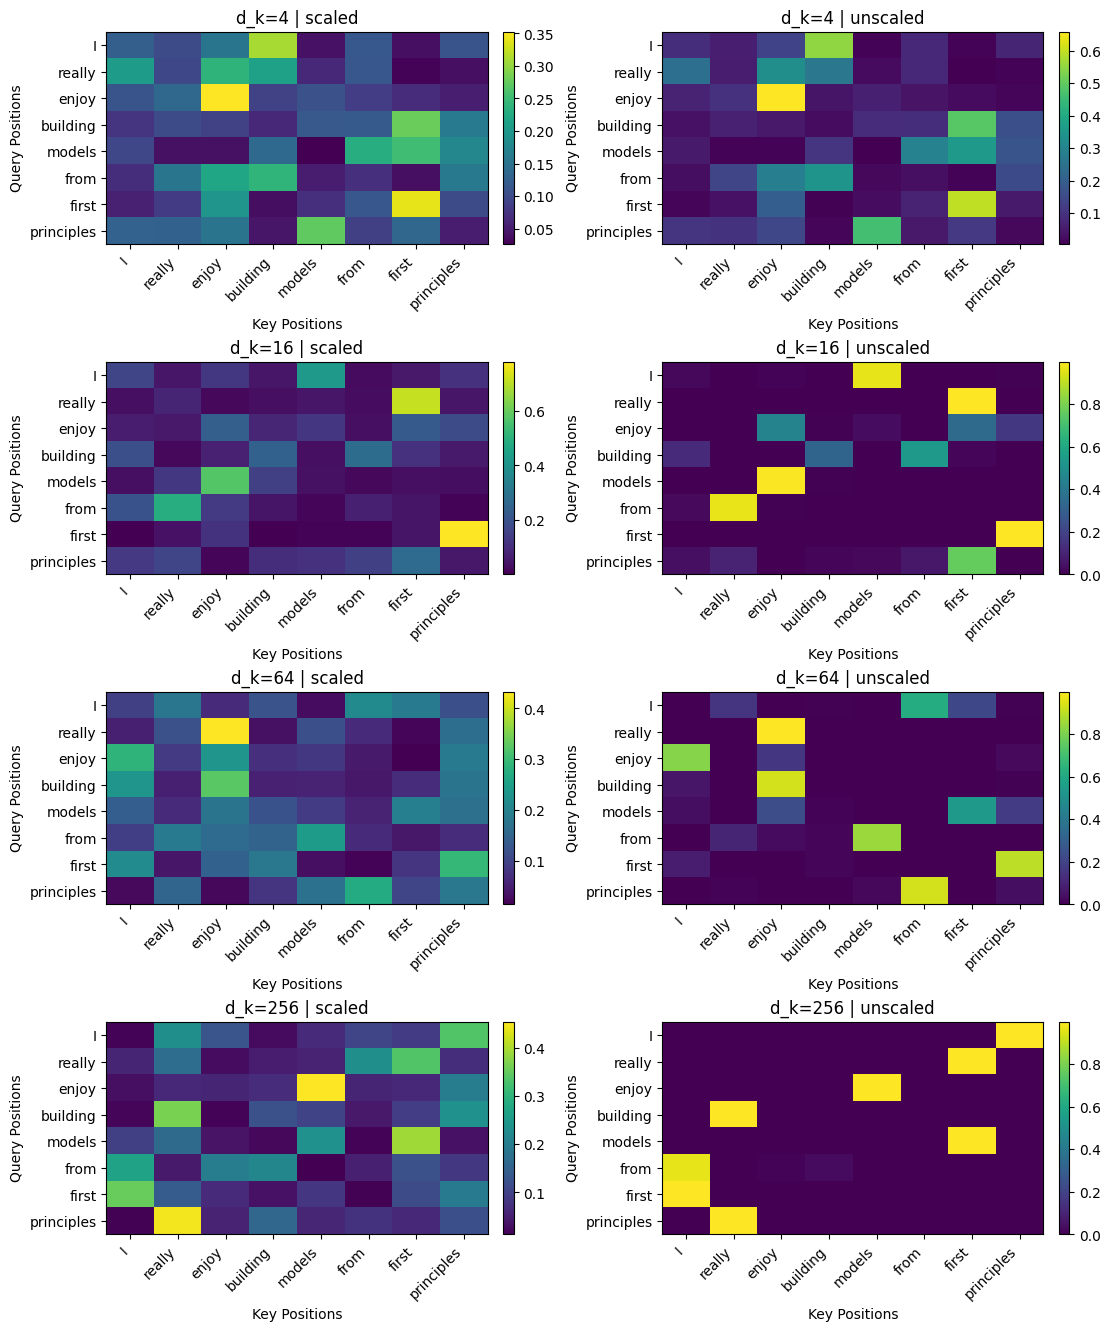

In [26]:
fig, axes = plt.subplots(len(d_k_values), 2, figsize=(11, 3.3 * len(d_k_values)), constrained_layout=True)

for i, d_k in enumerate(d_k_values):
    w_scaled = weights_lookup[(d_k, True)]
    w_unscaled = weights_lookup[(d_k, False)]

    plot_attention_heatmap(
        w_scaled,
        x_labels=token_labels,
        y_labels=token_labels,
        title=f"d_k={d_k} | scaled",
        ax=axes[i, 0],
    )
    plot_attention_heatmap(
        w_unscaled,
        x_labels=token_labels,
        y_labels=token_labels,
        title=f"d_k={d_k} | unscaled",
        ax=axes[i, 1],
    )

save_current_figure("attention_heatmap_gallery.png")
plt.show()


This figure shows why the √dₖ scaling factor in dot-product attention is needed. As the key/query dimension (dₖ) increases, the **unscaled** attention maps become increasingly sharp and nearly one-hot: a single token goes twards 1 while the rest go toward zero. By dₖ = 64 and especially 256, the softmax saturates, producing extremely peaky distributions that would lead to tiny gradients and unstable training. 

The **scaled** attention maps remain smooth and well-distributed across all dimensions, even as dₖ grows. The scaling factor prevents the dot products from exploding in magnitude, keeps the softmax distubition more robust, and preserves gradient flow. The key takeaway is that scaling is not just cosmetic, it is what makes attention stable and trainable at realistic embedding sizes.

In [27]:
for d_k in d_k_values:
    row_scaled = results_df[(results_df["d_k"] == d_k) & (results_df["scaled"])].iloc[0]
    row_unscaled = results_df[(results_df["d_k"] == d_k) & (~results_df["scaled"])].iloc[0]

    print(f"d_k={d_k}")
    print(
        f"Scaled attention stays broader (entropy={row_scaled['mean_entropy']:.3f}) "
        f"compared to unscaled (entropy={row_unscaled['mean_entropy']:.3f})."
    )
    print(
        f"Unscaled attention is sharper (max={row_unscaled['mean_max_weight']:.3f}) "
        f"than scaled (max={row_scaled['mean_max_weight']:.3f})."
    )
    print()


d_k=4
Scaled attention stays broader (entropy=1.896) compared to unscaled (entropy=1.490).
Unscaled attention is sharper (max=0.472) than scaled (max=0.285).

d_k=16
Scaled attention stays broader (entropy=1.517) compared to unscaled (entropy=0.440).
Unscaled attention is sharper (max=0.834) than scaled (max=0.470).

d_k=64
Scaled attention stays broader (entropy=1.850) compared to unscaled (entropy=0.525).
Unscaled attention is sharper (max=0.824) than scaled (max=0.283).

d_k=256
Scaled attention stays broader (entropy=1.726) compared to unscaled (entropy=0.030).
Unscaled attention is sharper (max=0.994) than scaled (max=0.368).



## Results & Interpretation

Expected trend in this controlled setup:
- entropy usually drops as d_k increases in the **unscaled** condition
- max attention weight usually rises in the **unscaled** condition
- **scaled** metrics are generally more stable across `d_k`

How heatmaps help:
- metrics quantify sharpness globally
- heatmaps show where each query collapses to near one-hot attention

Limitations:
- synthetic random Q/K/V rather than learned representations
- no full training loop or downstream task
- exact values vary with random seed

Tradeoff:
- sharper attention can help selectivity, but extreme saturation can hurt optimization dynamics.


### Summary From This Run
The cell below show side-by-side scaled vs unscaled metrics and prints deltas for each d_k.

In [28]:
pivot = results_df.pivot(index='d_k', columns='scaled', values=['mean_max_weight', 'mean_entropy', 'grad_norm_q', 'grad_norm_k'])
pivot.columns = [f"{metric}_{'scaled' if scaled else 'unscaled'}" for metric, scaled in pivot.columns]
pivot = pivot.reset_index()

pivot['delta_max_weight_unscaled_minus_scaled'] = pivot['mean_max_weight_unscaled'] - pivot['mean_max_weight_scaled']
pivot['delta_entropy_unscaled_minus_scaled'] = pivot['mean_entropy_unscaled'] - pivot['mean_entropy_scaled']

display(pivot.round(4))

for _, row in pivot.iterrows():
    d_k = int(row['d_k'])
    print(f"d_k={d_k}: max_weight delta (unscaled-scaled) = {row['delta_max_weight_unscaled_minus_scaled']:.4f}, "
          f"entropy delta (unscaled-scaled) = {row['delta_entropy_unscaled_minus_scaled']:.4f}")


,d_k,mean_max_weight_unscaled,mean_max_weight_scaled,mean_entropy_unscaled,mean_entropy_scaled,grad_norm_q_unscaled,grad_norm_q_scaled,grad_norm_k_unscaled,grad_norm_k_scaled,delta_max_weight_unscaled_minus_scaled,delta_entropy_unscaled_minus_scaled
0,4,0.4724,0.2854,1.4905,1.8962,0.1725,0.0490,0.1605,0.0528,0.1870,-0.4058
1,16,0.8344,0.4698,0.4404,1.5174,0.1966,0.0828,0.2280,0.0937,0.3645,-1.0770
2,64,0.8241,0.2827,0.5253,1.8497,0.4892,0.0307,0.5210,0.0352,0.5414,-1.3244
3,256,0.9942,0.3680,0.0296,1.7256,0.1760,0.0394,0.1890,0.0416,0.6263,-1.6960


d_k=4: max_weight delta (unscaled-scaled) = 0.1870, entropy delta (unscaled-scaled) = -0.4058
d_k=16: max_weight delta (unscaled-scaled) = 0.3645, entropy delta (unscaled-scaled) = -1.0770
d_k=64: max_weight delta (unscaled-scaled) = 0.5414, entropy delta (unscaled-scaled) = -1.3244
d_k=256: max_weight delta (unscaled-scaled) = 0.6263, entropy delta (unscaled-scaled) = -1.6960


### Final interpretation with concrete numbers

In [29]:
row_4 = pivot[pivot['d_k'] == 4].iloc[0]
row_256 = pivot[pivot['d_k'] == 256].iloc[0]

print(
    f"At d_k=4, unscaled max weight exceeds scaled by "
    f"{row_4['delta_max_weight_unscaled_minus_scaled']:.4f}, "
    f"and entropy is lower by {abs(row_4['delta_entropy_unscaled_minus_scaled']):.4f}."
)
print(
    f"At d_k=256, unscaled max weight exceeds scaled by "
    f"{row_256['delta_max_weight_unscaled_minus_scaled']:.4f}, "
    f"and entropy is lower by {abs(row_256['delta_entropy_unscaled_minus_scaled']):.4f}."
)

trend_strength = row_256['delta_max_weight_unscaled_minus_scaled'] - row_4['delta_max_weight_unscaled_minus_scaled']
print(
    f"The sharpness gap grows by {trend_strength:.4f} from d_k=4 to d_k=256, ")


At d_k=4, unscaled max weight exceeds scaled by 0.1870, and entropy is lower by 0.4058.
At d_k=256, unscaled max weight exceeds scaled by 0.6263, and entropy is lower by 1.6960.
The sharpness gap grows by 0.4392 from d_k=4 to d_k=256, 


## Conclusion
- The 1/sqrt(d_k) term is used for stability and gradient behavior, not just becuase.
- In this run, scaling prevents attention from becoming excessively peaked at larger dimensions.
- Combined metrics and heatmaps create a clear, explainable story showing theory and observed behavior.

If I continued further, I would:
- add causal and padding masks
- test multi-head specialization
- compare outputs against PyTorch built-in attention for parity checks

## Gradient Norm Experiment

gradient norms were already shown in the sweep, this plot makes gradient-flow comparison prettier across d_k.


Saved: outputs/gradient_norms_vs_dk.png


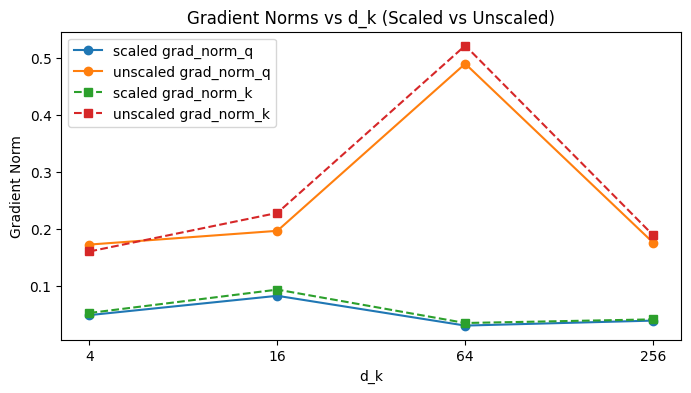

In [30]:
fig, ax = plt.subplots(figsize=(8, 4))

scaled_rows = results_df[results_df["scaled"]].sort_values("d_k")
unscaled_rows = results_df[~results_df["scaled"]].sort_values("d_k")

ax.plot(scaled_rows["d_k"], scaled_rows["grad_norm_q"], marker="o", label="scaled grad_norm_q")
ax.plot(unscaled_rows["d_k"], unscaled_rows["grad_norm_q"], marker="o", label="unscaled grad_norm_q")
ax.plot(scaled_rows["d_k"], scaled_rows["grad_norm_k"], marker="s", linestyle="--", label="scaled grad_norm_k")
ax.plot(unscaled_rows["d_k"], unscaled_rows["grad_norm_k"], marker="s", linestyle="--", label="unscaled grad_norm_k")

ax.set_xscale("log", base=2)
ax.set_xticks([4, 16, 64, 256])
ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())
ax.set_xlabel("d_k")
ax.set_ylabel("Gradient Norm")
ax.set_title("Gradient Norms vs d_k (Scaled vs Unscaled)")
ax.legend()
save_current_figure("gradient_norms_vs_dk.png")
plt.show()


This plot also shows without √dₖ scaling, gradient magnitudes become unstable as dimensionality increases. The unscaled gradients for both queries and keys grow substantially—peaking around dₖ = 64, showing that the softmax is entering a saturated state where small changes in logits produce disproportionately large or erratic gradient signals. However with scaled gradients, it remain consistently small and stable across all values of dₖ, showing that scaling keeps the attention mechanism in a better range. Scaling does not just smooth attention visually, it stabilizes backpropagation. Without it, larger embedding dimensions can cause gradient spikes or instability, making optimization harder and less predictable.
